In [1]:
!nvidia-smi

Tue Sep 21 16:42:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P5    10W /  N/A |    638MiB /  5934MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers datasets

In [3]:
import torch
import random
import numpy as np
import time
import datetime
import seaborn as sns
import pandas as pd
import os
import pathlib
import json
import math
import re
from random import randrange
import multiprocessing
import datasets
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, GPTNeoForCausalLM
from transformers import AdamW, get_cosine_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
from transformers import Trainer, TrainingArguments, TrainerCallback

In [4]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 2213719763


In [5]:
if os.path.isdir("/opt/awsw"):
  # In case we run this locally (in Docker)
  work_dir = os.path.join("/opt", "awsw")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  work_dir = os.path.join("/content", "drive", "MyDrive", "endless_awsw")

models_dir = os.path.join(work_dir, "models")

if not os.path.isdir(models_dir):
    pathlib.Path(models_dir).mkdir(parents=True, exist_ok=True)
    
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
# model = GPT2LMHeadModel.from_pretrained('EleutherAI/gpt-neo-125M', pad_token_id = tokenizer.pad_token_id)
model = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M', pad_token_id = tokenizer.pad_token_id, bos_token_id=tokenizer.bos_token_id, eos_token_id=tokenizer.eos_token_id)
model.config.attention_dropout = 0.1
model.config.embed_dropout = 0.1
print(f"Loading empty, pre-trained model.")

model.to(device)
model.resize_token_embeddings(len(tokenizer))
print(f"Model attached to {device_name}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading empty, pre-trained model.
Model attached to cuda:0


# Split data

In [6]:
with open(os.path.join(work_dir, "awsw_story_input.txt")) as f:
    data = f.read()
lines = data.split("\n")
player_dragon_pairs = {}
last_player_talk = []
closed_player_talk = False
re_player_talk = re.compile(r'c "(.*?)"')
for line in lines:
    line = line.strip()
    line_split = line.split(" ")
    if len(line_split) <= 1:
        continue
    
    if line_split[0] == "c":
        if closed_player_talk:
            closed_player_talk = False
            last_player_talk = []
        last_player_talk.append(re.sub(re_player_talk, r"\1", line))
    else:
        if not closed_player_talk:
            last_player_talk = json.dumps(last_player_talk)
            if not last_player_talk in player_dragon_pairs:
                player_dragon_pairs[last_player_talk] = []
            closed_player_talk = True
            
        line = "DragonReply " + line
        if last_player_talk is not None:
            player_dragon_pairs[last_player_talk].append(line)
    
train_lines = []
eval_lines = []
eval_per_character = 0

for player_line_str in player_dragon_pairs.keys():
    player_lines = json.loads(player_line_str)
    dragon_lines = player_dragon_pairs[player_line_str]
    compiled_line = " ".join([f'PlayerReply c "{player_line}"' for player_line in player_lines]) + " " + " ".join(dragon_lines)
    train_lines.append(compiled_line)
    
test_bucket = {}
for l in train_lines:
    l_split = l.split(" ")
    character = None
    for i, ls in enumerate(l_split):
        if ls == "DragonReply":
            character = l_split[i + 1]
            break
    if not character in test_bucket:
        test_bucket[character] = []
    test_bucket[character].append(l)
    
for i in range(eval_per_character):
    for character in test_bucket.keys():
        random_line = test_bucket[character][randrange(len(test_bucket[character]))]
        eval_lines.append(random_line)
        for i2, t in enumerate(train_lines):
            if t == random_line:
                del train_lines[i2]
                break
    
joined_eval_lines = "\n".join(eval_lines[:5])
print(f"eval_lines: {joined_eval_lines}")
joined_train_lines = "\n".join(train_lines[:5])
print(f"train_lines: {joined_train_lines}")

if not os.path.isfile(os.path.join(work_dir, "data_train.txt")):
    with open(os.path.join(work_dir, "data_train.txt"), "w") as f:
        for l in train_lines:
            f.write(l + "\n")
            
if not os.path.isfile(os.path.join(work_dir, "data_test.txt")):
    with open(os.path.join(work_dir, "data_test.txt"), "w") as f:
        for l in eval_lines:
            f.write(l + "\n")

eval_lines: 
train_lines: PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."
PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"
PlayerReply c "Can't say I have." PlayerReply c "A few times." PlayerReply c "Once or twice." DragonReply Ry "I see." DragonReply Ry "Well, what do you think of it?"
PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."
PlayerReply c "It's pretty romantic." DragonReply Ry shy "You think so?"


In [7]:
dataset = load_dataset('text', data_files={'train': os.path.join(work_dir, "data_train.txt"), 'test': os.path.join(work_dir, "data_test.txt")})

class AWSWDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset, dataset_type):
        self.current_dataset = dataset
        self.dataset_type = dataset_type
        self.map_dataset()
        self.current_idx = 0
        
    def approx_len(self):
        return len(self.mapped_dataset[self.dataset_type])
        
    def shuffle_awsw_data(self):
        print("do shuffle")
        self.current_dataset = self.current_dataset.shuffle()
        self.map_dataset()
        
    def map_dataset(self):
        self.mapped_dataset = self.current_dataset.map(
            group_texts,
            batched=True,
            batch_size=dataset_batch_size,
            num_proc=dataset_map_cores
        )
        
    def __next__(self):
        if self.current_idx >= len(self.mapped_dataset[self.dataset_type]):
            raise StopIteration
        else:    
            item = self.mapped_dataset[self.dataset_type][self.current_idx]
            self.current_idx += 1
            return item
        
    def __iter__(self):
        self.current_idx = 0
        print("doing iter")
        return self
    
def encode(batch):
    result = []
    attention_mask = []
    for item in batch['text']:
        tokens = [tokenizer.bos_token_id] + tokenizer.encode(item) + [tokenizer.eos_token_id]
        result.append(tokens)
        attention_mask.append([1] * len(tokens))
    return {
        'attention_mask': attention_mask,
        'input_ids': result
    }

def group_texts(examples):
    # Make a max size
    block_size = 128
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Pad the end
    to_add = (math.ceil(total_length / block_size) * block_size) - total_length
    if to_add > 0:
        concatenated_examples['input_ids'] += [tokenizer.pad_token_id] * to_add
        concatenated_examples['attention_mask'] += [0] * to_add
        total_length += to_add
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

def map_dragon_reply_text(batch):
    # Make a max size
    block_size = 128
    result = {'text': []}
    for item in batch['text']:
        item_split = item.split(" ")
        player_replies = []
        dragon_replies = []
        current_reply = []
        handling_reply = None
        for token in item_split:
            if token == "PlayerReply":
                if handling_reply is None:
                    handling_reply = "PlayerReply"
                else:
                    if handling_reply == "PlayerReply":
                        # We need to store the PlayerReply
                        player_replies.append(" ".join(current_reply))
                        current_reply = []
            elif token == "DragonReply":
                if handling_reply == "DragonReply":
                    # We need to store the DragonReply
                    dragon_replies.append(" ".join(current_reply))
                    current_reply = []
                    
                if handling_reply == "PlayerReply":
                    # We need to store the PlayerReply
                    player_replies.append(" ".join(current_reply))
                    current_reply = []
                    
                handling_reply = "DragonReply"
                current_reply = []
                    
            if handling_reply is not None:
                current_reply.append(token)
                
        # There's always a dragon reply at the end.
        dragon_replies.append(" ".join(current_reply))
        for player_idx in range(len(player_replies)):
            for dragon_idx in range(len(dragon_replies)):
                result['text'].append(player_replies[player_idx] + " " + dragon_replies[dragon_idx])
                
    return result

dataset_map_cores = min(multiprocessing.cpu_count(), 10)
dataset_batch_size = 1000

dataset = dataset.map(
    map_dragon_reply_text,
    batched=True,
    batch_size=dataset_batch_size,
    num_proc=dataset_map_cores
)

dataset = dataset.map(
    encode,
    batched=True,
    batch_size=dataset_batch_size,
    remove_columns=["text"],
    num_proc=dataset_map_cores
)

# dataset = dataset.map(
#     group_texts,
#     batched=True,
#     batch_size=dataset_batch_size,
#     num_proc=dataset_map_cores
# )

def test_dataset(awsw_dataset):
    iter_dataset = iter(awsw_dataset)
    for i in range(5):
        item = next(iter_dataset)
        print(f"Item {i}: {tokenizer.decode(item['labels'])}")
    print("--------\nShuffle...\n--------")
    awsw_dataset.shuffle_awsw_data()
    iter_dataset = iter(awsw_dataset)
    for i in range(5):
        item = next(iter_dataset)
        print(f"Item {i}: {tokenizer.decode(item['labels'])}")
    print("--------\nShuffle again...\n--------")
    awsw_dataset.shuffle_awsw_data()
    iter_dataset = iter(awsw_dataset)
    for i in range(5):
        item = next(iter_dataset)
        print(f"Item {i}: {tokenizer.decode(item['labels'])}")

test_dataset(AWSWDataset(dataset, 'train'))
train_awsw_dataset = AWSWDataset(dataset, 'train')

doing iter
Item 0: <|startoftext|> PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."<|endoftext|> <|startoftext|> PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"<|endoftext|> <|startoftext|> PlayerReply c "Can't say I have." DragonReply Ry "I see."<|endoftext|> <|startoftext|> PlayerReply c "Can't say I have." DragonReply Ry "Well, what do you think of it?"<|endoftext|> <|startoftext|> PlayerReply c "A few times." DragonReply Ry "I see."<|endoftext|> <|startoftext|> PlayerReply c "A few times." Dragon
Item 1: Reply Ry "Well, what do you think of it?"<|endoftext|> <|startoftext|> PlayerReply c "Once or twice." DragonReply Ry "I see."<|endoftext|> <|startoftext|> PlayerReply c "Once or twice." DragonReply Ry "Well, what do you think of it?"<|endoftext|> <|startoftext|> PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."<|endoftext|> <|sta

In [13]:
batch_size = 5
train_len = train_awsw_dataset.approx_len()
num_training_steps = math.ceil(train_len / batch_size)
num_epoch = 10
num_total_steps = num_training_steps * num_epoch
num_warmup_steps = num_training_steps * 2
print(f"num_training_steps: {num_training_steps} num_total_steps: {num_total_steps}")
def get_optimizer_and_scheduler(params):
    optimizer = AdamW(params)
#     scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_total_steps)
    scheduler = get_polynomial_decay_schedule_with_warmup(optimizer, num_warmup_steps, num_total_steps, power=0.2, lr_end=1e-10)
    return optimizer, scheduler

num_training_steps: 887 num_total_steps: 8870


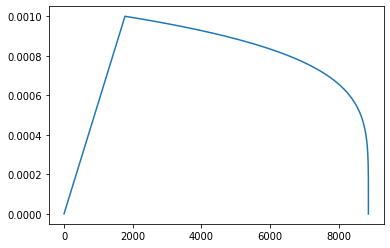

In [15]:
lrs = []
optimizer, scheduler = get_optimizer_and_scheduler([torch.tensor(0.1)])
for i in range(num_total_steps):
    optimizer.step()
    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(lrs)
plt.show()
del lrs
del optimizer
del scheduler

max_steps is given, it will override any value given in num_train_epochs
***** Running training *****
  Num examples = 44350
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 8870


do shuffle
doing iter


Step,Training Loss
250,16.824300
500,5.559300
750,3.744900
1000,3.233400
1250,2.996600
1500,2.914400
1750,2.839000
2000,2.670500
2250,2.544300
2500,2.506600


Saving model checkpoint to /opt/awsw/models/checkpoint-500
Configuration saved in /opt/awsw/models/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/checkpoint-500/pytorch_model.bin


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-1000
Configuration saved in /opt/awsw/models/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/checkpoint-1500
Configuration saved in /opt/awsw/models/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-500] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-2000
Configuration saved in /opt/awsw/models/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-2500
Configuration saved in /opt/awsw/models/checkpoint-2500/config.json
Model weights saved in /opt/awsw/models/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-1500] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-3000
Configuration saved in /opt/awsw/models/checkpoint-3000/config.json
Model weights saved in /opt/awsw/models/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-2000] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-3500
Configuration saved in /opt/awsw/models/checkpoint-3500/config.json
Model weights saved in /opt/awsw/models/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-2500] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-4000
Configuration saved in /opt/awsw/models/checkpoint-4000/config.json
Model weights saved in /opt/awsw/models/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-3000] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-4500
Configuration saved in /opt/awsw/models/checkpoint-4500/config.json
Model weights saved in /opt/awsw/models/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-3500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-5000
Configuration saved in /opt/awsw/models/checkpoint-5000/config.json
Model weights saved in /opt/awsw/models/checkpoint-5000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-4000] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-5500
Configuration saved in /opt/awsw/models/checkpoint-5500/config.json
Model weights saved in /opt/awsw/models/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-4500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-6000
Configuration saved in /opt/awsw/models/checkpoint-6000/config.json
Model weights saved in /opt/awsw/models/checkpoint-6000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-5000] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-6500
Configuration saved in /opt/awsw/models/checkpoint-6500/config.json
Model weights saved in /opt/awsw/models/checkpoint-6500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-5500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-7000
Configuration saved in /opt/awsw/models/checkpoint-7000/config.json
Model weights saved in /opt/awsw/models/checkpoint-7000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-6000] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-7500
Configuration saved in /opt/awsw/models/checkpoint-7500/config.json
Model weights saved in /opt/awsw/models/checkpoint-7500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-6500] due to args.save_total_limit


do shuffle
doing iter


Saving model checkpoint to /opt/awsw/models/checkpoint-8000
Configuration saved in /opt/awsw/models/checkpoint-8000/config.json
Model weights saved in /opt/awsw/models/checkpoint-8000/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-7000] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/checkpoint-8500
Configuration saved in /opt/awsw/models/checkpoint-8500/config.json
Model weights saved in /opt/awsw/models/checkpoint-8500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/checkpoint-7500] due to args.save_total_limit


do shuffle
doing iter




Training completed. Do not forget to share your model on huggingface.co/models =)




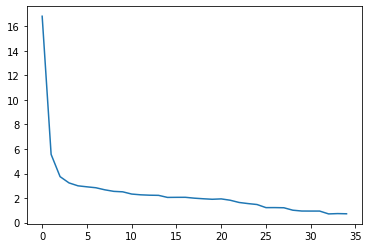

In [16]:
class AWSWTrainer(Trainer):
    def _get_train_sampler(self):
        return None
    
class AWSWTrainerCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        train_awsw_dataset.shuffle_awsw_data()
    
    def on_train_end(self, args, state, control, **kwargs):
        loss_history = [h['loss'] for h in state.log_history if 'loss' in h]
        plt.plot(loss_history)
        plt.show()
        
def train(model):
    optimizer, scheduler = get_optimizer_and_scheduler(model.parameters())
    training_args = TrainingArguments(
        models_dir,
        seed=seed,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epoch,
        save_total_limit=2,
        save_steps=500,
        logging_steps=250,
        max_steps=num_total_steps
    )
    trainer = Trainer(
        model=model, 
        args=training_args, 
        train_dataset=train_awsw_dataset,
        #eval_dataset=dataset['test'],
        optimizers=(optimizer, scheduler),
        callbacks=[AWSWTrainerCallback]
    )
    checkpoint_dirs = [os.path.join(models_dir, d) for d in os.listdir(models_dir) if os.path.isdir(os.path.join(models_dir, d))]
    if len(checkpoint_dirs) > 0:
        latest_checkpoint = max(checkpoint_dirs, key=os.path.getmtime)
        trainer.train(latest_checkpoint)
    else:
        trainer.train()

train(model)

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [ ]:
def generate_dragon_reply(past, prompt, top_k=None, top_p=None):
    block_size = 128
    model.eval()
    prompt = f'{past} PlayerReply c "{prompt}" DragonReply'
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
        generated, 
        do_sample=(top_k is not None and top_p is not None),
        top_p=top_p,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        max_length=block_size,
        num_return_sequences=1
    )
    return tokenizer.decode(sample_outputs[0], skip_special_tokens=False)[len(prompt):].strip()

prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "That\'s awesome. He\'s a cute fellow."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

# Set a fixed seed to make sure we get the same response every time.
torch.manual_seed(80085)
for (past, prompt) in prompts:
    reply = generate_dragon_reply(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: An "I'm not sure how you can eat that cheese stuff."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Lo relieved "I don't know. I don't think he's a person anymore."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: An "I see."<|endoftext|>


Prompt: What will we do here?
Reply: Ry "I'm glad you're not going to put anything into jeopardy. I'm sure the council treats you nicely."<|endoftext|>




# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = generate_dragon_reply(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

In [ ]:
def generate_reply(prompt):
  model.eval()
  prompt = f'PlayerReply c "{prompt}" DragonReply'
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  print(prompt, generated)

  sample_outputs = model.generate(
    generated, 
    do_sample=True,   
    eos_token_id=tokenizer.eos_token_id,
    top_k=50, 
    max_length = 128,
    top_p=0.95, 
    num_return_sequences=3
  )

  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))

print("What to say?")
print(generate_reply(input()))